In [1]:
import wandb
import tensorflow as tf
from wandb.keras import WandbCallback
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from scipy import stats
import random
from scipy.stats import sem
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [6]:
jerks_path = "Dataset/Appropriateness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path = "Dataset/Appropriateness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path = "Dataset/Appropriateness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

rms_properties_path = "Dataset/Appropriateness_Features/RMS_Energy_properties.csv"
XX_rms_energy_properties = pd.read_csv(rms_properties_path, index_col = False) # With Name of StudySeq

rms_distance_path = "Dataset/Appropriateness_Features/RMS_Distance_scores_fd_scaled.csv"
XX_rms_distance_scores = pd.read_csv(rms_distance_path)
XX_rms_distance_scores.drop(XX_rms_distance_scores.columns[1], axis=1, inplace=True) # Dropping the Spine joint (always 0)

labels_path = "Dataset/Appropriateness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"

XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})
XY = XY.join(XX_rms_distance_scores)
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_rms_distance_scores'})

# Join the RMS Energy Properties Features
XY = XY.rename(columns={'Unnamed: 0_jerks': 'StudySeq'})
XY['StudySeq'] = XY['StudySeq'].apply(lambda x: x[8:])
XY = XY.join(XX_rms_energy_properties, rsuffix='_rms')
for i in range(1,int(XY.shape[0]/40)):
    XY.iloc[i*40:(i+1)*40,-5:] = XX_rms_energy_properties
    
# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
# Also Drop the Index from rms_energy
XY.drop(['StudySeq','Unnamed: 0_YY','Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels',
        'Unnamed: 0_rms_distance_scores', 'Unnamed: 0', 'StudySeq_rms'], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[0:14], XY.columns[0:14] + '_jerks'))
XY = XY.rename(columns=rename_dict)

# Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + 14 RMS Energy Distance Scores + 3 RMS Energy Property Features + Label for MOS = 137
print(XY.shape)

XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
bad_features = ['LeftShoulder_vs_LeftArm', 'LeftArm_vs_LeftForeArm', 'LeftForeArm_vs_LeftHand',
                'RightShoulder_vs_RightArm', 'RightArm_vs_RightForeArm','RightForeArm_vs_RightHand']
XX.drop(bad_features, axis=1, inplace=True)
YY = XY.loc[:,'Mean_Appropriateness_Score']
XX = np.log(XX)
XX.iloc[:,-17:-3] = XX.iloc[:,-17:-3]

index_to_reduce = [x for x in range(0,20)] + [x for x in range (80,100)] + [x for x in range(240,260)]
XX = XX.iloc[index_to_reduce,:]
YY_genea = YY[index_to_reduce]
YY_genea.index = np.arange(0, len(index_to_reduce))
YY_survey = pd.read_csv('Dataset/Appropriateness_Labels/survey_labels.csv').loc[:,'Mean_Appropriateness_Score']
YY_combined = pd.read_csv('Dataset/Appropriateness_Labels/combined_labels.csv').loc[:,'Mean_Appropriateness_Score']
print(XX.shape)
print(YY_genea.shape)
print(YY_survey.shape)
print(YY_combined.shape)

(360, 137)
(60, 130)
(60,)
(60,)
(60,)


In [7]:
def predicted_vs_true(model, XX, YY, epochs, validation_split, batch_size, callback):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    folds = outer_loop_cv.split(XX)
    count = 1
    YY_train_true = []
    YY_train_preds = []
    YY_preds = []
    YY_true = []
    model.save_weights('initial_app.h5')
    for train, test in folds:
        model.load_weights('initial_app.h5')
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        XX_test= XX.iloc[test]
        YY_test = YY.iloc[test]
        YY_train, YY_test = YY_train.values.flatten(), YY_test.values.flatten()
        
        model.fit(XX_train, YY_train, epochs=epochs, validation_split=validation_split,
                  batch_size=batch_size, verbose = 0, callbacks = [callback])
        
        YY_train_preds = YY_train_preds + list(model.predict(XX_train))
        YY_train_true = YY_train_true + list(YY_train)
        
        YY_pred = model.predict(XX_test).flatten()
        
        YY_true = YY_true + list(YY_test)
        YY_preds = YY_preds + list(YY_pred)
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
    
    m, b = np.polyfit(YY_preds, YY_true, 1)
    x = np.arange(0,101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.scatter(YY_preds, YY_true, s=7.5, alpha=0.8, label='Predictions')
    plt.plot(x, y*m + b, '-c', label="Regression Line for predictions")
    plt.plot(x, y, "-k", label="Regression Line for p=1", alpha=0.5)
    plt.title("Predictions of ANN on Test Set")
    plt.ylabel("True Appropriateness")
    plt.xlabel("Predicted Appropriateness")
    plt.xticks(np.linspace(0,100,11))
    plt.yticks(np.linspace(0,100,11))
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.legend()

    rho, pval = stats.spearmanr(YY_true, YY_preds)
    print("Pearson Correlation Coefficient =", rho)
    print("Test Mean Squared Error = ", mean_squared_error(YY_true, YY_preds, squared=True))
    print("Train Mean Squared Error = ", mean_squared_error(YY_train_true, YY_train_preds, squared=True))

# ANN - GENEA Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.7749249761883334
Test Mean Squared Error =  105.62776759461038
Train Mean Squared Error =  49.270122022290565
Time taken:  11.306995630264282


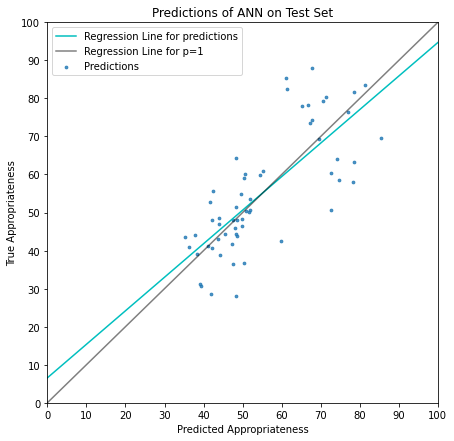

In [10]:
start_time = time.time()
model = Sequential()
model.add(Dense(14, input_dim=130, activation='relu')) # hidden layer 1
model.add(Dense(14)) #2 
model.add(Dense(14)) #3 
model.add(Dense(14)) #4 
model.add(Dense(14)) #5 
model.add(Dense(14)) #6
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='mse')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
predicted_vs_true(model, XX, YY_genea, 1000, 0, 48, callback)
print("Time taken: ", time.time() - start_time)

# ANN - Survey Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.8105532249093091
Test Mean Squared Error =  55.87411457399099
Train Mean Squared Error =  34.61858737084902
Time taken:  11.195336103439331


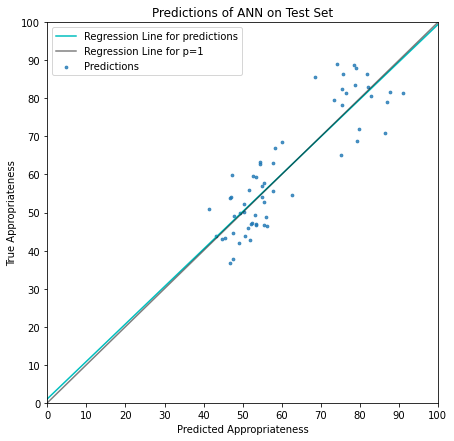

In [11]:
start_time = time.time()
model = Sequential()
model.add(Dense(14, input_dim=130, activation='relu')) # hidden layer 1
model.add(Dense(14)) #2 
model.add(Dense(14)) #3 
model.add(Dense(14)) #4 
model.add(Dense(14)) #5 
model.add(Dense(14)) #6
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='mse')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
predicted_vs_true(model, XX, YY_survey, 1000, 0, 48, callback)
print("Time taken: ", time.time() - start_time)

# ANN - Combined Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.7929980550152822
Test Mean Squared Error =  88.88443612480728
Train Mean Squared Error =  52.15504744968545
Time taken:  10.660512208938599


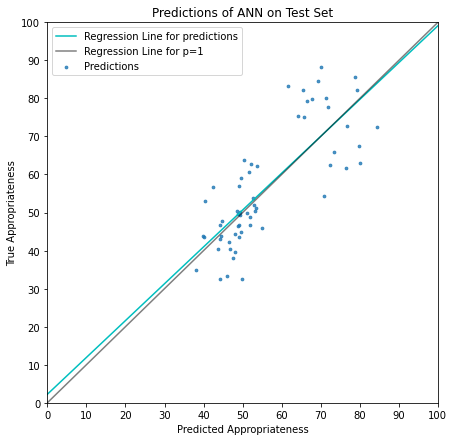

In [13]:
start_time = time.time()
model = Sequential()
model.add(Dense(14, input_dim=130, activation='relu')) # hidden layer 1
model.add(Dense(14)) #2 
model.add(Dense(14)) #3 
model.add(Dense(14)) #4 
model.add(Dense(14)) #5 
model.add(Dense(14)) #6
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='mse')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
predicted_vs_true(model, XX, YY_combined, 1000, 0, 48, callback)
print("Time taken: ", time.time() - start_time)